# Rolling Fourier Ring Correlation Map

A quick notebook implementation of rolling Fourier Ring Correlation (rFRC) map.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from skimage import filters
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import pandas as pd
from scipy.fftpack import fft2, fftshift, ifft2

# Add the relative path to ../SRmetric
sys.path.append(os.path.abspath(os.path.join('..')))

from SRmetric.metric import *
from SRmetric.utils import *

## Load Image

In [2]:
WF_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3_20241031_130414_WF.tif"
SR_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3.mrc"

# WF_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3_20241031_145214_WF.tif"
# SR_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3.mrc"

In [3]:
wf_img = im_read(WF_PATH)
sr_img = im_read(SR_PATH)

print(wf_img.shape)
print(sr_img.shape)

voxel size: (0.03065, 0.03065, 0.05)
(1024, 1024)
(3, 1024, 1024)


/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:238: RuntimeWarning: Machine stamp '0x00 0x00 0x00 0x00' does not match the apparent byte order '>'
  warnings.warn(msg.format(pretty_machst, header.mode.dtype.byteorder),


## Plot Self Rolling FRC

Processing FRC resolution patches: 100%|██████████| 3969/3969 [00:00<00:00, 4521.91it/s]
/tmp/ipykernel_2926082/1912798611.py:321: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


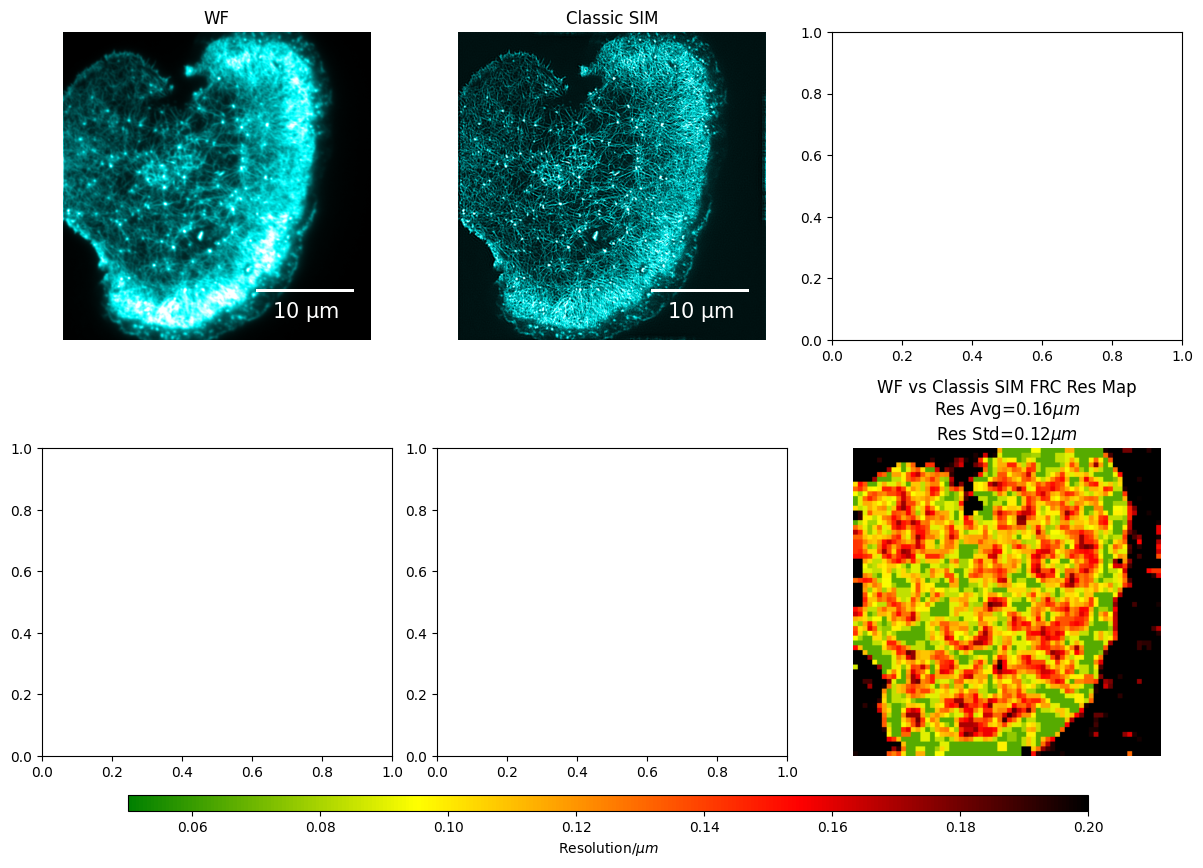

In [20]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Try importing CuPy
try:
    import cupy as cp
    GPU_AVAILABLE = cp.is_available()
except ImportError:
    GPU_AVAILABLE = False

class ResolutionMap:
    """
    A Python class object to compute superresolution quality metric

    Attributes:
    -----------
    img1: numpy.ndarray
        2D numpy array of image to compute resolution
    img2: numpy.ndarray (optional)
        2D numpy array of processed image. Necessary only for relative rolling FRC between two images of same size.
    window_size: int (default=32)
        Size of the sliding window.
    stride: int (default=16)
        Stride between windows.
    frc_threshold: float (default=1/7)
        Threshold to determine resolution from FRC.
    sampling: int (default=1)
        Sampling rate if the image has been pre-upsampled
    sampling_method: str (default="max")
        Downsampling method, choose from ["max","skipping","Fourier"]
    pixel_size: float (default=1)
        Physical pixel size of the image, in um
    """

    def __init__(self, 
                img1,
                img2 = None,
                window_size = 32,
                stride = 16,
                frc_threshold = 1/7,
                sampling = 1,
                samping_method = "max",
                pixel_size=1,
                verbose = True,
                ):
        assert len(img1.shape) == 2, "img1 must be a 2D numpy array"
        self.img1 = img1
        if img2 is not None:
            assert len(img2.shape) == 2, "img2 must be a 2D numpy array"
            assert img1.shape == img2.shape, "Both images must have the same shape."
        self.img2 = img2

        self.window_size=window_size
        self.stride=stride
        self.frc_threshold=frc_threshold
        self.sampling=sampling
        self.sampling_method=samping_method
        self.pixel_size=pixel_size
        self.verbose = verbose

        # automatically detect to use gpu
        self.use_gpu = GPU_AVAILABLE
        self.backend = cp if self.use_gpu else np

        if self.use_gpu:
            if verbose:
                print("CUDA GPU detected, running on GPU")
                self.img1 = cp.asarray(img1)
                if img2 is not None:
                    self.img2 = cp.asarray(img2)
            else:
                print("CUDA GPU not available, running on CPU")

        self.ring_radii = self.backend.arange(1,window_size//2)
        self.resolution_map = self.backend.zeros_like(self.img1, dtype=self.backend.float32)
        self.weight_map = self.backend.zeros_like(self.img1, dtype=self.backend.float32)

    def rolling_window(self, img1, img2, flip_tile=False):
        """
        Generate rolling window patches from the image.
        """
        h, w = self.img1.shape
        windows = []
        for i in range(0, h - self.window_size + 1, self.stride):
            for j in range(0, w - self.window_size + 1, self.stride):
                patch1 = img1[i:i+self.window_size, j:j+self.window_size]
                patch2 = img2[i:i+self.window_size, j:j+self.window_size]
                windows.append((patch1,patch2,(i,j),flip_tile))
        return windows

    def compute_resolution(self, frc_values):
        """
        Determine the resolution where FRC falls below the threshold.

        Parameters:
            frc_values (ndarray): Array of FRC values.

        Returns:
            int: Index of the frequency ring corresponding to resolution.
        """
        for i, frc in enumerate(frc_values):
            if frc < self.frc_threshold:
                # Calculate spatial frequency: (i+1) accounts for 1-based ring index
                spatial_frequency = (i + 1) / (self.window_size * self.pixel_size)
                return 1 / spatial_frequency  # Return spatial resolution in physical units

        # If threshold is never crossed, return the coarsest resolution
        spatial_frequency = len(frc_values) / (self.window_size * self.pixel_size)
        return 1 / spatial_frequency

    def fourier_ring_correlation(self, img1, img2, flip_tile=False):
        """
        Compute the Fourier Ring Correlation (FRC) between two images.

        Parameters:
            img1 (ndarray): First image (windowed region).
            img2 (ndarray): Second image (windowed region).
            flip_tile (book): Perform flipped tiling before FFT

        Returns:
            frc_values (ndarray): FRC values for each ring radius.
        """
        backend = self.backend
        if flip_tile:
            img1 = image_flip_tile(img1)
            img2 = image_flip_tile(img2)

        F1 = backend.fft.fftshift(backend.fft.fft2(img1))
        F2 = backend.fft.fftshift(backend.fft.fft2(img2))

        # Create radial rings
        ny, nx = img1.shape
        y, x = backend.indices((ny, nx))
        center_y, center_x = ny // 2, nx // 2
        r = backend.sqrt((x - center_x)**2 + (y - center_y)**2)

        frc_values = []
        for radius in self.ring_radii:
            mask = (r >= radius - 0.5) & (r < radius + 0.5)
            F1_ring = F1[mask]
            F2_ring = F2[mask]

            numerator = backend.sum(F1_ring * backend.conj(F2_ring))
            denominator = backend.sqrt(backend.sum(backend.abs(F1_ring)**2) * backend.sum(backend.abs(F2_ring)**2))
            frc = backend.abs(numerator) / (denominator + 1e-8)
            frc_values.append(frc)

        return backend.array(frc_values)

    def process_patch(self, args):
        """Process a single patch for resolution computation."""
        patch1, patch2, position, _ = args
        frc_values = self.fourier_ring_correlation(patch1, patch2)
        resolution = self.compute_resolution(frc_values)
        return position, resolution

    def process_srFRC_patch(self,args):
        """Process a single patch for srFRC resolution computation."""
        patch1, patch2, position, flip_tile = args
        frc_values = self.fourier_ring_correlation(patch1, patch2, flip_tile)

    @staticmethod
    def _init_worker(instance):
        """Initialize workers with a class instance."""
        global obj
        obj = instance

    @staticmethod
    def _process_patch_proxy(args):
        """Proxy to call the instance's worker function."""
        return obj.process_patch(args) 
    
    @staticmethod
    def _process_srFRC_patch_proxy(args):
        """Proxy to call the instance's worker function."""
        return obj.process_patch(args) 

    def compute_srFRC_map(self):
        """
        Compute self rolling FRC of image 1
        """

        if self.sampling_method == "max":
            # Ensure the array dimensions are divisible by 2
            assert self.img1.shape[0] % self.sampling == 0 and self.shape[1] % self.sampling == 0, "Array dimensions must be divisible by sampling rate {}.".format(sampling_rate[i])

            # Reshape the array then perform max pooling
            reshaped = img.reshape(img.shape[0] // self.sampling, self.sampling, img.shape[1] // self.sampling, self.sampling)
            img = reshaped.max(axis=(1, 3))
            img1 = self.img1[::2, ::2]
            img2 = self.img1[1::2, 1::2]

        windows = self.rolling_window(img1,img2)

        if self.use_gpu:
            raise NotImplementedError("srFRC with gpu not implemented")
        else:
            # CPU parallel processing using multiprocessing
            with Pool(processes=cpu_count(), initializer=self._init_worker, initargs=(self,)) as pool:
                for position, resolution in tqdm(pool.imap_unordered(self._process_srFRC_patch_proxy,windows),total=len(windows),desc="Processing self FRC resolution patches"):
                    i, j = position
                    self.resolution_map[i*self.sampling:(i+self.window_size)*self.sampling,j*self.sampling:(j+self.window_size)*self.sampling] = resolution
                    self.weight_map[i*self.sampling:(i+self.window_size)*self.sampling,j*self.sampling:(j+self.window_size)*self.sampling] += 1
        
        # Normalize resolution map by weight map
        self.resolution_map = self.resolution_map / (self.weight_map + 1e-8)  # Avoid division by zero

        if self.use_gpu:
            return cp.asnumpy(self.resolution_map)
        else:
            return self.resolution_map

    def compute_rrFRC_map(self):
        """
        Compute relative rolling FRC between input images 1 and 2
        """
        if self.img2 is None:
            raise AssertionError("Image 2 not provided")
        
        windows = self.rolling_window(self.img1, self.img2, flip_tile=False)

        if self.use_gpu:
            # GPU inherently runs parallel
            for patch1, patch2, position in windows:
                position, resolution = self.process_patch((patch1, patch2, position))
                i, j = position
                self.resolution_map[i:i+self.window_size, j:j+self.window_size] = resolution
                self.weight_map[i:i+self.window_size, j:j+self.window_size] += 1
        else:
            # CPU parallel processing using multiprocessing
            with Pool(processes=cpu_count(), initializer=self._init_worker, initargs=(self,)) as pool:
                for position, resolution in tqdm(pool.imap_unordered(self._process_patch_proxy,windows),total=len(windows),desc="Processing FRC resolution patches"):
                    i, j = position
                    self.resolution_map[i:i+self.window_size, j:j+self.window_size] += resolution
                    self.weight_map[i:i+self.window_size, j:j+self.window_size] += 1

        # Normalize resolution map by weight map
        self.resolution_map = self.resolution_map / (self.weight_map + 1e-8)  # Avoid division by zero

        if self.use_gpu:
            return cp.asnumpy(self.resolution_map)
        else:
            return self.resolution_map

PX_SIZE = 0.03065
SAMPLING_RATE= 1

# rrFRC
rm = ResolutionMap(
    wf_img,
    sr_img[0],
    pixel_size=PX_SIZE,
    window_size=32,
    stride=16,
    )

rrFRC_map = rm.compute_rrFRC_map()

# # srFRC for image 1
# rm1 = ResolutionMap(
#     wf_img,
#     pixel_size=PX_SIZE,
#     sampling=2
#     )
# srFRC_map_1 = rm1.compute_srFRC_map()

# srFRC for image 2

fig, axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].imshow(wf_img,vmin=np.percentile(wf_img,1),vmax=np.percentile(wf_img,99.5),cmap=cyan_hot_cmap)
axs[0,0].set_axis_off()
axs[0,0].set_title("WF")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,0].add_artist(scalebar)

axs[0,1].imshow(sr_img[0],vmin=np.percentile(sr_img[0],1),vmax=np.percentile(sr_img[0],99.5),cmap=cyan_hot_cmap)
axs[0,1].set_axis_off()
axs[0,1].set_title("Classic SIM")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,1].add_artist(scalebar)

# im = axs[1,0].imshow(rrFRC_map,vmin=0,vmax=0.2,cmap="inferno_r")
im = axs[1,2].imshow(rrFRC_map,vmin=0.05,vmax=0.2,cmap=res_cmap)
axs[1,2].set_axis_off()
axs[1,2].set_title(r"WF vs Classis SIM FRC Res Map"
                   "\nRes Avg={:.2f}$\mu m$"
                   "\nRes Std={:.2f}$\mu m$".format(np.mean(rrFRC_map),np.std(rrFRC_map))
                   )

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.1, -0.02, 0.8, 0.02]) # figure normalized x, y, w, h
cbar = fig.colorbar(im, cax=cbar_ax,orientation="horizontal") 
cbar.set_label(r"Resolution/$\mu m$")

fig.tight_layout()